<a href="https://colab.research.google.com/github/Felhaba/Modelling/blob/main/CreditCalibration_Vol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from bs4 import BeautifulSoup
from scipy.optimize import fsolve

In [ ]:
path = '/content/drive/MyDrive/Programming/Junk/'

* The input data is a series of $n$ credit curves (CDS market quotes) at dates $t_i$, for $i \in [1, n]$;
* We suppose that the recovery rate is known and fixed at $40\%$. Then we do the following classical approximation to get the default spread curves: $\Lambda (t, T) = \dfrac{CR(t, T)}{LGD}$, with $\Lambda (t, T)$ is the default intensity (probablity of default on the hotizon $[t, T]$) at date $t$ for the horizon $T$, and $LGD$ is the Loss Given Default such as: $LGD = 1 - RR$.

### Egypt Vol

In [ ]:
df_egypt = pd.read_csv(f'{path}EGYPT_CN1702823.csv', sep = ',') # pd.read_excel(f'{path}USD.csv', 'USD')

In [ ]:
df_egypt.head(3)

,dates,0.5,1,2,3,4,5,7,10,15,20,30
0,3/26/2021,0.000661,0.004150,0.017839,0.043436,0.069330,0.097505,0.144789,0.204661,0.273963,0.321513,0.382589
1,3/29/2021,0.000753,0.004714,0.019166,0.044627,0.070768,0.099728,0.149153,0.208060,0.277738,0.325564,0.387758
2,3/30/2021,0.000930,0.005121,0.019748,0.045648,0.071892,0.100994,0.149580,0.208441,0.277842,0.325552,0.387622


In [ ]:
df_egypt['dates'] = pd.to_datetime(df_egypt['dates'], format='%m/%d/%Y')

In [ ]:
df_egypt['Delta'] = df_egypt['dates'].diff().dt.days #days difference

In [ ]:
#coumpute default intensity
df_egypt[df_egypt.columns[1::]] = df_egypt[df_egypt.columns[1::]].div(0.6)

For variance estimation the folowing process is considered:
$$D_i^{CIR}(\tau) = \dfrac{\Lambda_{i+1} (t, T) - \Lambda_{i} (t, T)}{\sqrt{\lambda_i}}$$
with instantaneous  default intensity observations $(\lambda_i)_{1 \leq i \leq n}$.

This delta can be seen as normalized change in default intensity/probablity of default for a given time horizon.

In [ ]:
#D_i CIR by pillar
df_egypt_di = pd.DataFrame()

for i in df_egypt.columns[1:12]:
  name = 'Di_' + i
  df_egypt_di[name] = df_egypt[i].diff()/np.sqrt(df_egypt[i].shift(1))

df_egypt_di.head(2)

,Di_0.5,Di_1,Di_2,Di_3,Di_4,Di_5,Di_7,Di_10,Di_15,Di_20,Di_30
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.004665,0.011305,0.012826,0.007381,0.007048,0.009192,0.014806,0.009702,0.009313,0.009224,0.010787


let's define $\tau = T - t$

In [ ]:
#(T-t) by pillar
for i in df_egypt.columns[1:12]:
  name = '(T-t)' + i
  df_egypt[name] = float(i) - df_egypt['Delta']/365

# df_egypt.head(3)

,dates,0.5,1,2,3,4,5,7,10,15,...,(T-t)1,(T-t)2,(T-t)3,(T-t)4,(T-t)5,(T-t)7,(T-t)10,(T-t)15,(T-t)20,(T-t)30
0,2021-03-26,0.001101,0.006917,0.029731,0.072393,0.115551,0.162508,0.241315,0.341101,0.456605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-29,0.001256,0.007857,0.031943,0.074379,0.117947,0.166214,0.248588,0.346767,0.462897,...,0.986301,1.986301,2.986301,3.986301,4.986301,6.986301,9.986301,14.986301,19.986301,29.986301
2,2021-03-30,0.001550,0.008536,0.032914,0.076079,0.119820,0.168323,0.249300,0.347401,0.463071,...,0.995434,1.995434,2.995434,3.995434,4.995434,6.995434,9.995434,14.995434,19.995434,29.995434


In [ ]:
cnt = df_egypt.shape[0] #count the number of rows
days_diff = (df_egypt['dates'].iloc[-1] - df_egypt['dates'].iloc[0]).days #number of days in the df
Delta = days_diff/(365*(cnt-1))
a = 0.03 #externally defined
Tau = df_egypt.columns[1:12] #list of pillars

In [ ]:
#compute historical std
std_stat = list(df_egypt_di.std(axis = 0))

Least Square Minimization or L2-Norm. The min function is $\sum\limits_{j=1}^p (\sqrt{Var_{stat}[D_{CIR}](\tau_j)} - \sqrt{Var_{CIR}[D_{CIR}](\tau_j)})^2$, With $Var_{CIR}$ being the theoretical variance, and $Var_{stat}$ stands for
statistical variance.

$Var_{CIR} \left[ D^{CIR} (\tau) \right]= \frac{\Delta}{\tau^2}\left( \sigma B^{CIR}(\tau) \right)^2$ - from this equation we are looking for a standartized $\sigma$ that can be seen as a risk-neutral volatility implied form the credit market data. This value is seen in GUI's CVA Historical Calibration menu.

In [ ]:
# Define the function
def root(x):
  std_Di = []
  for t in Tau:
    tau = float(t)
    h = (a**2+2*x**2)**0.5
    B = 2*np.exp(tau*h)/(2*h+(a+h)*np.exp(tau*h)-1)
    var_Di = Delta * (B*x/tau)**2
    std_Di.append(var_Di**0.5)
  # sum_diff = sum(np.square(np.array(std_Di) - np.array(std_stat)))
  # print(sum_diff)
  return std_Di

In [ ]:
b = 0.001
while abs(sum(np.square(np.array(root(b)) - np.array(std_stat)))) > 0.01:
  b += 0.01
print(b) #root(b)

0.031


In [ ]:
#Excel's root
sum(np.square(np.array(root(0.842026424393183)) - np.array(std_stat)))

0.010310285959446464

In [ ]:
#GUI's root
sum(np.square(np.array(root(1)) - np.array(std_stat)))

0.010524349466730776

In [ ]:
#Python's root
sum(np.square(np.array(root(0.028000000000000018)) - np.array(std_stat)))

0.009984443908609867

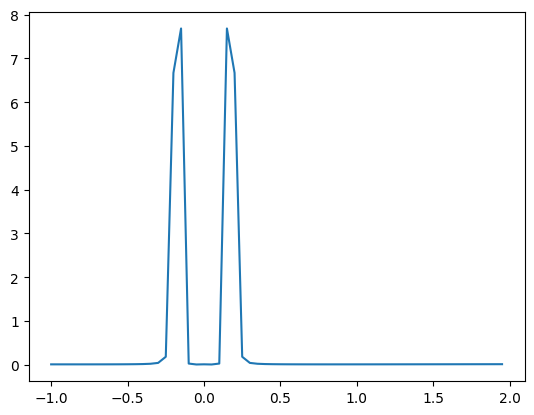

In [ ]:
# setting the x - coordinates
x = np.arange(-1, 2, 0.05)
# setting the corresponding y - coordinates
y = [sum(np.square(np.array(root(i)) - np.array(std_stat))) for i in x]

# plotting the points
plt.plot(x, y)

# function to show the plot
plt.show()